## 概要

記事[「量子アニーリングを用いたグラフ彩色」](https://qard.is.tohoku.ac.jp/T-Wave/?p=2510)では貪欲法でグラフ彩色を行うときに独立点集合を量子アニーリングで求めたときと古典コンピュータで求めたときとで最適化性能の比較を行った論文を紹介しました。本記事ではこの手法を用いて実際にグラフ彩色を行います。また論文では頂点数が20、40、60のときで実験を行い、これより頂点数が多いグラフについては量子アニーリングの優位性は不明でした。本記事では頂点数を80、100としたときでも性能比較を行います。

## 文献情報



*   タイトル：Graph Coloring with Quantum Annealing
*   著者：Julia Kwok, Kristen Pudenz
*   書誌情報：https://arxiv.org/abs/2012.04470



## 問題

グラフ彩色における貪欲法は独立点集合に1色ずつ割り当てることを繰り返してグラフ彩色を行います。詳細は[「量子アニーリングを用いたグラフ彩色」](https://qard.is.tohoku.ac.jp/T-Wave/?p=2510)を参照してください。

## 実験

まずは必要なライブラリをインストールします。

In [ ]:
!pip install dwave-ocean-sdk
!pip install openjij
!pip install numpy
!pip install matplotlib
!pip install networkx

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from itertools import product, combinations
from networkx.algorithms.approximation import clique

# D-waveマシンの場合
from dwave.system import DWaveSampler, EmbeddingComposite

# SAの場合
from openjij import SASampler

古典コンピュータで独立点集合を求めます。具体的にはSampleISというアルゴリズムによって最大独立点集合を求めます。SampleISについては[「最大独立点集合問題における貪欲アルゴリズムの紹介」](https://qard.is.tohoku.ac.jp/T-Wave/?p=2827)を参照してください。

In [ ]:
def independent_set_classical(g, k):
    # 頂点数が1以下の時はグラフの頂点を返す
    if g.number_of_nodes() <= 1:
        return set(g.nodes())

    # n:グラフの頂点数
    n = g.number_of_nodes()

    while True:
        # log_{k}^{n}個頂点をランダムに選ぶ(i)
        i = set(
            random.sample(
                list(g.nodes()), np.floor(max(1, np.log(n) / np.log(k))).astype(int)
            )
        )

        # Iが独立点集合かどうか判定
        is_independent = True
        for u, v in product(i, i):
            if (u, v) in list(g.edges()):
                is_independent = False

        # Iが独立点集合の時
        if is_independent == True:
            # Iに含まれる頂点とIと隣接している頂点
            node_neighbors = i
            for v in i:
                node_neighbors = node_neighbors | set(g.neighbors(v))

            # Iのどの頂点とも隣接していない頂点の部分グラフ
            non_neighbors = g.subgraph(set(g.nodes() - node_neighbors)).copy()

            if non_neighbors.number_of_nodes() >= (n / k) * np.log(n) / (
                2 * np.log(np.log(n))
            ):
                return i | independent_set_classical(non_neighbors, k)

            else:
                # clique_removalで求まった独立点集合
                i2 = clique.clique_removal(non_neighbors)[0] | i

                # I_2に含まれる頂点の数が(np.power(np.log(n), 3)/(6*np.log(np.log(n))))より大きいなら結果を返す
                if len(i2) >= np.floor(
                    np.power(np.log(n), 3) / (6 * np.log(np.log(n)))
                ).astype(int):
                    return i2 | i

実際にSampleISで独立点集合を求めてみます。

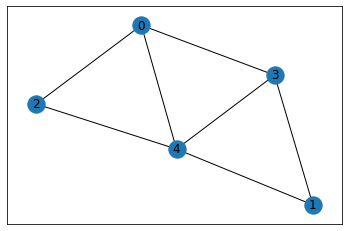

独立点集合:{1, 2}


In [ ]:
g = nx.fast_gnp_random_graph(5, 0.3)
independent_set = independent_set_classical(g, 3)
nx.draw_networkx(g)
plt.show()
print(f"独立点集合:{independent_set}")

次に量子アニーリングを使って独立点集合を求めます。定式化は以下の通りです。

$f_{MIS}(x) = - \sum_{i}^{n}x_{i} + \alpha \sum_{i, j \in E}x_{i}x_{j}$

In [ ]:
def independent_set_quantum(g, sampler, **sampler_params):
    # 頂点数
    n = g.number_of_nodes()

    # グラフの頂点番号
    nodes = list(g.nodes())

    # QUBOを作成
    qubo = {}

    # 頂点数を多くするための項
    for i in range(n):
        qubo[(i, i)] = -1

    # 独立点集合にするための項
    for (u, v) in g.edges():
        qubo[(nodes.index(u), nodes.index(v))] = qubo[
            (nodes.index(v), nodes.index(u))
        ] = 2

    # アニーリングの実行
    sampleset = sampler.sample_qubo(qubo, **sampler_params)

    # 最も頂点数の多い独立点集合
    max_independent_set = {}

    for sample in sampleset.record.sample:
        # 独立点集合か判定
        is_independent = True

        for (u, v) in g.edges():
            if sample[nodes.index(u)] == 1 and sample[nodes.index(v)] == 1:
                is_independent = False

        if is_independent:
            independent_set = set([nodes[i] for i in range(n) if sample[i] == 1])

            # 頂点数が多い方の独立点集合を求める
            if len(independent_set) > len(max_independent_set):
                max_independent_set = independent_set

    return max_independent_set

量子アニーリングで独立点集合を求めてみます。

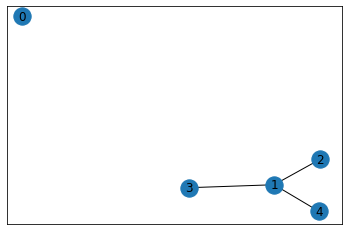

独立点集合:{0, 2, 3, 4}


In [ ]:
# サンプラーの設定
# SAの場合
# sampler = SASampler()

# D-waveマシンの場合
sampler_config = {"solver": "DW_2000Q_6", "token": "YOUR_TOKEN"}
sampler = EmbeddingComposite(DWaveSampler(**sampler_config))

g = nx.fast_gnp_random_graph(5, 0.3)
independent_set = independent_set_quantum(g, sampler=sampler, num_reads=30)
nx.draw_networkx(g)
plt.show()
print(f"独立点集合:{independent_set}")

上記の関数を用いてグラフ彩色の関数を作成します。

In [ ]:
def graph_coloring_classical(g):
    # 現在の色
    color = 0

    # 彩色するためのグラフ
    coloring_graph = g.copy()

    # 頂点の色
    node_color = [None] * coloring_graph.number_of_nodes()

    while coloring_graph.number_of_nodes() > 0:
        # 独立点集合を求める
        max_independent_set = {}
        independent_set = independent_set_classical(coloring_graph.copy(), 3)

        s = 1
        for i in range(s):
            if len(independent_set) > len(max_independent_set):
                max_independent_set = independent_set

        # 求めた独立点集合に1色割り当てる
        for v in max_independent_set:
            node_color[v] = color

        if len(max_independent_set) > 0:
            # グラフから頂点を削除
            coloring_graph.remove_nodes_from(max_independent_set)
            color += 1

    return node_color

In [ ]:
def graph_coloring_quantum(g, sampler, **sampler_params):
    # 現在の色
    color = 0

    # 彩色したいグラフ
    coloring_graph = g.copy()

    # 頂点の色
    node_color = [None] * coloring_graph.number_of_nodes()

    while coloring_graph.number_of_nodes() > 0:
        # 独立点集合を求める
        max_independent_set = independent_set_quantum(
            coloring_graph.copy(), sampler=sampler, **sampler_params
        )

        # 求めた独立点集合に1色割り当てる
        for v in max_independent_set:
            node_color[v] = color

        if len(max_independent_set) > 0:
            # グラフから頂点を削除
            coloring_graph.remove_nodes_from(max_independent_set)
            color += 1

    return node_color

論文では彩色を行うグラフは3色で彩色可能なものを用いて実験を行いました。本記事では辺が存在しないグラフの頂点にあらかじめ3色のうちどれかの色を割り当て、異なる色の2頂点の間にランダムに辺を生成することでグラフを作成します。

In [ ]:
def make_random_graph(node_num=20, color_num=3, p=0.5):
    # 頂点番号
    num = [i for i in range(node_num)]

    # 空グラフを作成
    g = nx.empty_graph(node_num)

    # ランダムに色を割り当てる
    color = [random.randint(0, color_num - 1) for i in range(node_num)]

    # 色が異なる頂点の間にランダムに辺を生成
    for (u, v) in combinations(num, 2):
        if color[u] != color[v] and random.random() < p:
            g.add_edge(u, v)

    return g

実際にグラフ彩色を行います。今回は頂点数を10としてグラフ彩色を行います。

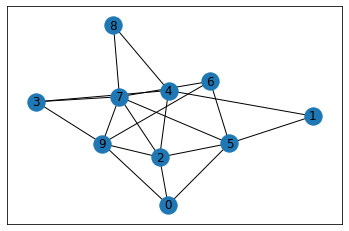

In [ ]:
g = make_random_graph(node_num=10, color_num=3, p=0.5)
nx.draw_networkx(g)
plt.show()

[1, 0, 0, 0, 1, 2, 0, 1, 0, 2]


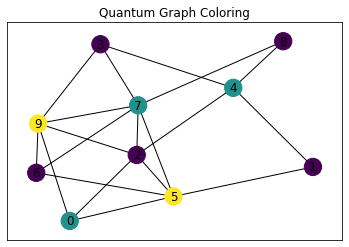

In [ ]:
# サンプラーの設定
# SAの場合
# sampler = SASampler()

# D-waveマシンの場合
sampler_config = {"solver": "DW_2000Q_6", "token": "YOUR_TOKEN"}
sampler = EmbeddingComposite(DWaveSampler(**sampler_config))

color_quantum = graph_coloring_quantum(g, sampler=sampler, num_reads=30)
print(color_quantum)
nx.draw_networkx(g, node_color=color_quantum)
plt.title("Quantum Graph Coloring")
plt.show()

[1, 0, 0, 0, 1, 2, 0, 1, 0, 2]


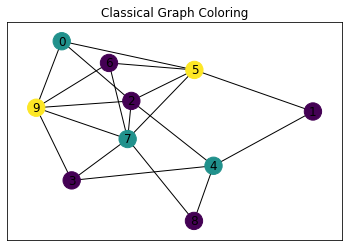

In [ ]:
color_classical = graph_coloring_classical(g)
print(color_classical)
nx.draw_networkx(g, node_color=color_classical)
plt.title("Classical Graph Coloring")
plt.show()

どちらも3色で彩色することができました。

いよいよ古典コンピュータと量子アニーリングの最適化性能の比較を行います。本記事では頂点数を20、40、60、80、100、辺を生成する確率は頂点数をnとしたとき4.5/nとして3色で彩色が可能なグラフを頂点数それぞれについて20個作成します。この20個のグラフを3色以下で彩色できた確率を求めます。

In [ ]:
success_probability_quantum = []
success_probability_classical = []

# サンプラーの設定
# SAの場合
# sampler = SASampler()

# D-waveマシンの場合
sampler_config = {"solver": "DW_2000Q_6", "token": "YOUR_TOKEN"}
sampler = EmbeddingComposite(DWaveSampler(**sampler_config))

for n in [20, 40, 60, 80, 100]:
    success_count_quantum = 0
    success_count_classical = 0

    for i in range(20):
        g = make_random_graph(node_num=n, color_num=3, p=4.5 / n)

        color_quantum = graph_coloring_quantum(g, sampler=sampler, num_reads=30)
        color_classical = graph_coloring_classical(g)

        if max(color_quantum) < 3:
            success_count_quantum += 1
        if max(color_classical) < 3:
            success_count_classical += 1

    success_probability_quantum.append(success_count_quantum / 20)
    success_probability_classical.append(success_count_classical / 20)

    print(f"頂点数:{n}")
    print(f"Quantum Success Probability:{success_count_quantum/20}")
    print(f"Classical Success Probability:{success_count_classical/20}")
    print("================================")

頂点数:20
Quantum Success Probability:0.45
Classical Success Probability:0.35
頂点数:40
Quantum Success Probability:0.4
Classical Success Probability:0.25
頂点数:60
Quantum Success Probability:0.2
Classical Success Probability:0.15
頂点数:80
Quantum Success Probability:0.1
Classical Success Probability:0.05
頂点数:100
Quantum Success Probability:0.05
Classical Success Probability:0.0


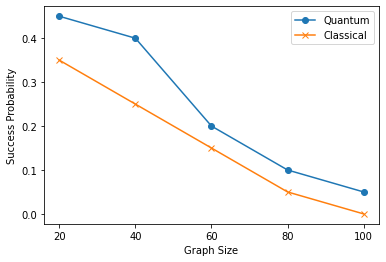

In [ ]:
graph_size = [20, 40, 60, 80, 100]
plt.plot(graph_size, success_probability_quantum, label="Quantum", marker="o")
plt.plot(graph_size, success_probability_classical, label="Classical", marker="x")
plt.xlabel("Graph Size")
plt.xticks(graph_size)
plt.ylabel("Success Probability")
plt.legend()
plt.show()

すべての頂点数において量子アニーリングを用いたときの方が古典コンピュータの時よりも成功確率は高くなりました。しかし頂点数が多くなると成功確率は低くなりました。

量子アニーリングの方が良かった理由としては求めた独立点集合の頂点数が多かったことが考えられます。

本記事では論文と同様の係数を用いましたが、制約項にかかる係数を調整することでより頂点数の多い独立点集合を求め成功確率を高められる可能性があります。論文では第一項の係数は-1に固定して第二項の係数を調整しましたが、第一項の係数も変化させることでより頂点数の多い独立点集合を求められると考えらえます。また古典コンピュータでのグラフ彩色ではランダムに頂点を選びながら独立点集合を求めましたが、例えば辺の数など選ぶ頂点に何か指標を設けることで古典コンピュータでの成功確率を上げることが考えられます。

一方で常に最大独立点集合を求めても最小の彩色数が得られないようなグラフが存在します。貪欲法でグラフ彩色を行うので、このようなグラフでは量子アニーリングの成功確率は小さくなると考えられます。

## 結論

今回の実験では論文よりも頂点数が多いグラフでも量子アニーリングが古典コンピュータよりも成功確率が高くなりました。頂点数が多くなると成功確率は低くなりました。今後の実験としては係数を調整して実際に量子アニーリングの成功確率が上がるのかを調べるなどがあります。

## あとがき

本記事では実際にグラフ彩色を行ってみました。頂点数が論文よりも多い場合より量子アニーリングの成功確率が高くなったのを確認できたのはよかったです。実際にコードを書いてみて、可読性などわかりやすいコードを書くのは色々な知識が足りていないなと感じました。